In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

from manage import (
    logging,
    TRAINING_DATA_FILE,
    EMBEDDINGS_SEQ_FILE,
    EMBEDDINGS_MUT_FILE,
    MUTATION_SCORES_FILE,
    SEQUENCE_MUTATION_PLOT,
    SEQUENCE_EMBEDDINGS_PLOT,
    plot_umap,
)


In [2]:
logging.info("Loading data..")

seq_mut: pd.DataFrame = pd.read_feather(TRAINING_DATA_FILE)
seq_embbeddings: pd.DataFrame = pd.read_csv(EMBEDDINGS_SEQ_FILE, index_col=0)
mut_embbeddings: pd.DataFrame = pd.read_csv(EMBEDDINGS_MUT_FILE, index_col=0)
mutation_scores: pd.DataFrame = pd.read_feather(MUTATION_SCORES_FILE)
mutation_scores: pd.DataFrame = mutation_scores.set_index("index")

[2022-01-12 04:15:35 PM]: Loading data..


In [3]:
pred_scores = mutation_scores.loc[~mutation_scores.index.isin(mut_embbeddings.index)]

In [4]:
true_scores = seq_mut.loc[~seq_mut["Accession"].isin(mut_embbeddings.index)]
true_scores = true_scores.pivot_table(
    index="Accession",
    columns="Mutation",
    values="Value",
    fill_value=0
)

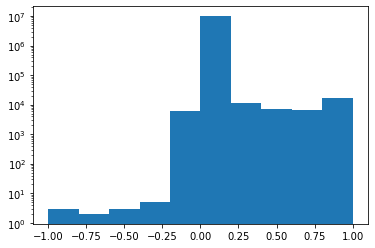

In [10]:
score_err = pred_scores.loc[true_scores.index] - true_scores

# n, bins, patches = plt.hist(score_err)
n, bins, patches = plt.hist(score_err.values.flatten())
plt.yscale("log")
plt.savefig("Plots/score_error.pdf")

In [6]:
all_pos = score_err.columns.str.extract("(\d+)").value_counts()
bad_muts = ((score_err > 0.5) | (score_err < -0.5)).sum(axis=0)
bad_muts = bad_muts[bad_muts > 20]
bad_pos = bad_muts.index.str.extract("(\d+)").values.flatten()


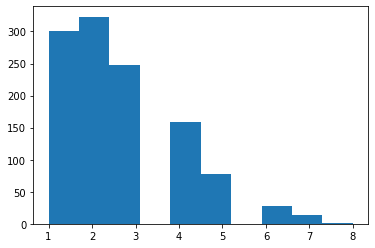

In [12]:
plt.hist(all_pos.values)
plt.savefig("Plots/duplicated_position.pdf")

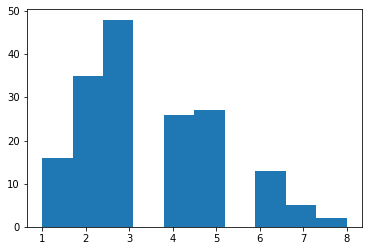

In [13]:
plt.hist(all_pos[np.unique(bad_pos)])
plt.savefig("Plots/duplicated_position_high_error.pdf")

[2022-01-12 04:15:45 PM]: Plot sequence umap


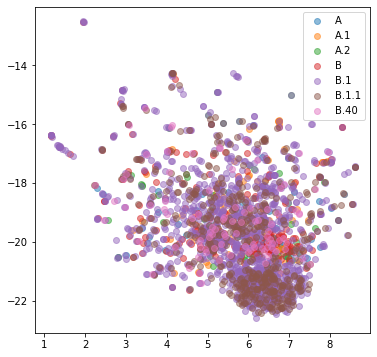

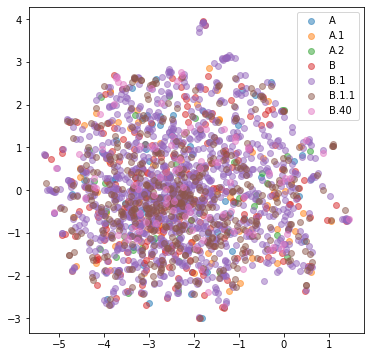

In [9]:
logging.info("Plot sequence umap")

seq_lineage = seq_mut[["Accession", "Lineage"]].drop_duplicates()
seq_lineage = seq_lineage.set_index("Accession")

plot_umap(true_scores, seq_lineage, SEQUENCE_MUTATION_PLOT)
plot_umap(pred_scores, seq_lineage, SEQUENCE_EMBEDDINGS_PLOT)
